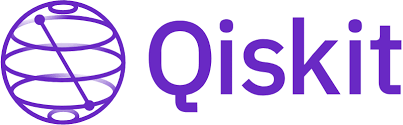

In [ ]:
!pip install qiskit qiskit_aer qiskit-ibm-runtime pylatexenc

In [ ]:
import qiskit
qiskit.version.get_version_info()

In [ ]:
import numpy as np

# 3. Simulaciones

Testea tus programas cuánticos ejecutandolos en dispositivos simulados y explorar su rendimiento bajo modelos de ruido de los dispositivos. Esto permite verificarlos antes de enviarlo a un sistema físico.



### 3.1.1 StatevectorSampler

El `StatevectorSampler`  puede tomar circuitos y parámetros como inputs y devuelve los resultados del sampleo de las distribuciones de probabilidades de los posibles estados.

Los outputs pueden ser expresados como un array de los valores sampleado o "cuentas" para cada bitstring presente en la distribución de los resultados.

Todo circuito dentro del `Sampler` debe incluir las mediciones.

In [ ]:
from qiskit import QuantumCircuit

# Ejemplo: Circuito de entrelazamiento

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)
qc.measure_all()
qc.draw(output='mpl')

In [ ]:
from qiskit.primitives import StatevectorSampler

sampler = StatevectorSampler()

# ejecuta el circuito qc
job = sampler.run([qc] , shots=128) #shots: cantidad de veces que corre el circuito
result = job.result()
print(f" > Result class: {type(result)}")

# Obtener los resultados
data = result[0].data

# Recuperar las bitstring de la medición
bitstrings = data.meas.get_bitstrings()
print(f"The number of bitstrings is: {len(bitstrings)}")

# Obtener las cuentas de las mediciones
counts = data.meas.get_counts()
print(f"The counts are: {counts}")


Podemos graficar estas cuentas mediante la funcion `plot_histogram` de `qiskit.visualization`.

In [ ]:
from qiskit.visualization import plot_histogram #herramienta de qiskit
#Graficamos las cuentas creadas anteriormente en un histogram
plot_histogram( counts )

**Ejercicio 1**: Construya un circuito que prepare y mida el estado cuántico
$$ |\psi\rangle = \frac{1}{\sqrt{2}}( |0\rangle - i |1\rangle ). $$
Tambien realice un gráfico de la cuentas. Hint: busque en el textbook de Qiskit la definición de la puerta de fase (compuerta S).

In [1]:
#Solución



**Ejercicio 2**: Construya un circuito que prepare y mida el estado cuántico
$$ |\psi\rangle = \frac{1}{2}( |00\rangle + |01\rangle + |10\rangle + |11\rangle  ). $$
Tambien realice un gráfico de la cuentas.

In [ ]:
# Solución



# 3.2 Simulaciones exactas y ruidosas con primitivas de Qiskit Aer

Los procesadores cuánticos que existen actualmente sufren de errores, o ruido, por lo que los resultados de las simulaciones exactas no reflejan necesariamente los resultados que se esperarian al correr circuitos en hardware real.
`Qiskit Aer` es un simulador de circuitos cuántico que puedes usar para mejor rendimiento y más funciones.


In [ ]:
# Ejemplo sobre 2 qubits
from qiskit.circuit.library import EfficientSU2

n_qubits = 2
circuit = EfficientSU2(n_qubits)

circuit.measure_all()

circuit.draw(output='mpl') #.decompose()

In [ ]:
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import Estimator

observable = SparsePauliOp("Z" * n_qubits)
params = [0.1] * circuit.num_parameters

exact_estimator = Estimator()
job = exact_estimator.run(circuit, observable, params)
exact_value = job.result().values[0]
exact_value


Ahora, incialicemos un modelo de ruido que incluye error depolarizador de 2% en cada compuerta CX. En la práctica, el error que surge de compuertas de 2 qubits son la mayor fuente de error cuando se corre un circuito.


Esto es que con probabilidad p= 0.02, el estado es remplazado con el estado completamente mixto, y el estado es preservado con probabilidad 1-p. Después de m aplicaciones del canal depolarizador, la probabilidad de que el estado se preserve sería de (1-p)^m. Por tanto se espera que el retener el estado correcto al final de la simulación decaiga exponencialmente con la cantidad de CXs en el circuito.

En la siguiente celda, construimos en Estimator que incorpora este modelo de ruido y lo usamos para computar el valor de expectación del observable.

In [ ]:
from qiskit_aer.noise import NoiseModel, depolarizing_error

noise_model = NoiseModel()
cx_depolarizing_prob = 0.02
noise_model.add_all_qubit_quantum_error(depolarizing_error(cx_depolarizing_prob, 2), ["cx"])

noisy_estimator = Estimator(backend_options={"noise_model": noise_model})
job = noisy_estimator.run(circuit, observable, params)
noisy_value = job.result().values[0]
noisy_value

In [ ]:
# La probabilidad de mantener el estado correcto alfinal del circuito
cx_count = circuit.decompose().count_ops()["cx"] #cantidad de cx
(1 - cx_depolarizing_prob) ** cx_count

**Ejercicio 3**: Construya un circuito que prepare el siguiente estado entrelazado de tres qubits

$$ |\psi\rangle = \frac{1}{\sqrt{2}}( |000\rangle + |111\rangle ). $$

Este estado fue introducido en 1989 por Daniel Greenberger, Michael Horne and Anton Zeilinger, y por eso es conocido como estado GHZ. Hay que destacar que Zeilinger fue galardonado el año 2022 con el premio Nobel de Física por su trabajo en información cuántica!

Utilice el `Statevector` para obtener el estado del ciruito y grafíquelo con la Q-esfera. Posteriormente, incluya mediciones en su circuito y utilice el `StatevectorSampler` para realizar la simulación del circuito. Grafique un histograma de las cuentas.

In [ ]:
# Escriba su solución aquí

# 4. Computadores cuánticos reales


También podemos ejecutar nuestros circuitos utilizando computadores cuánticos reales. Primero debemos guardar/cargar nuestra cuenta de IBM Quantum.

Los pasos a seguir son los siguientes:

### 4.1 Usando las credenciales de tu cuenta, autenticar el canal de tu preferencia(IBM Quantum Platform or IBM Cloud®).



In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService

TOKEN = '61eb667ba8db33f9344f6dd042ba7b409265878cf9bf6943ed7098146ebcd1abad1b5e0078570c543c16fab63413d4fa9929b5685824fdff369acf348c94ed42' #TOKEN tiene que estar entre comillas!!

# Guarda la cuenta de IBM Quantum y la fija como cuenta predeterminada.
QiskitRuntimeService.save_account(channel="ibm_quantum", token=TOKEN, set_as_default=True, overwrite=True)

# Cargar las credenciales guardadas.
service = QiskitRuntimeService()

# Entrega todos los backends disponibles de esta cuenta
service.backends()

[<IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('ibm_brisbane')>,
 <IBMBackend('ibm_kyoto')>,
 <IBMBackend('ibm_sherbrooke')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibm_osaka')>]

   ### 4.2 Elegir un sistema o simulador


In [ ]:
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)

# Compuertas base del backend elegido

basis_gates = list(backend.operation_names)
print(basis_gates)

['id', 'rz', 'sx', 'x', 'ecr', 'reset', 'measure', 'if_else', 'for_loop', 'switch_case', 'delay']


 ### 4.3 Enviar un job a un sistema o simulador.

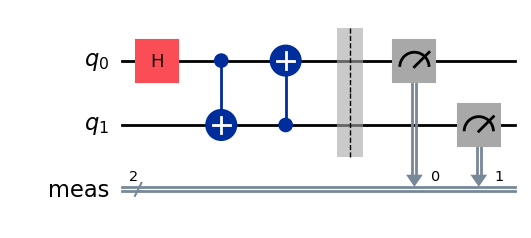

In [ ]:
# Crear un circuito

qc = QuantumCircuit(2)

qc.h(0)
qc.cx(0,1)
qc.cx(1,0)

qc.measure_all()

qc.draw(output='mpl')

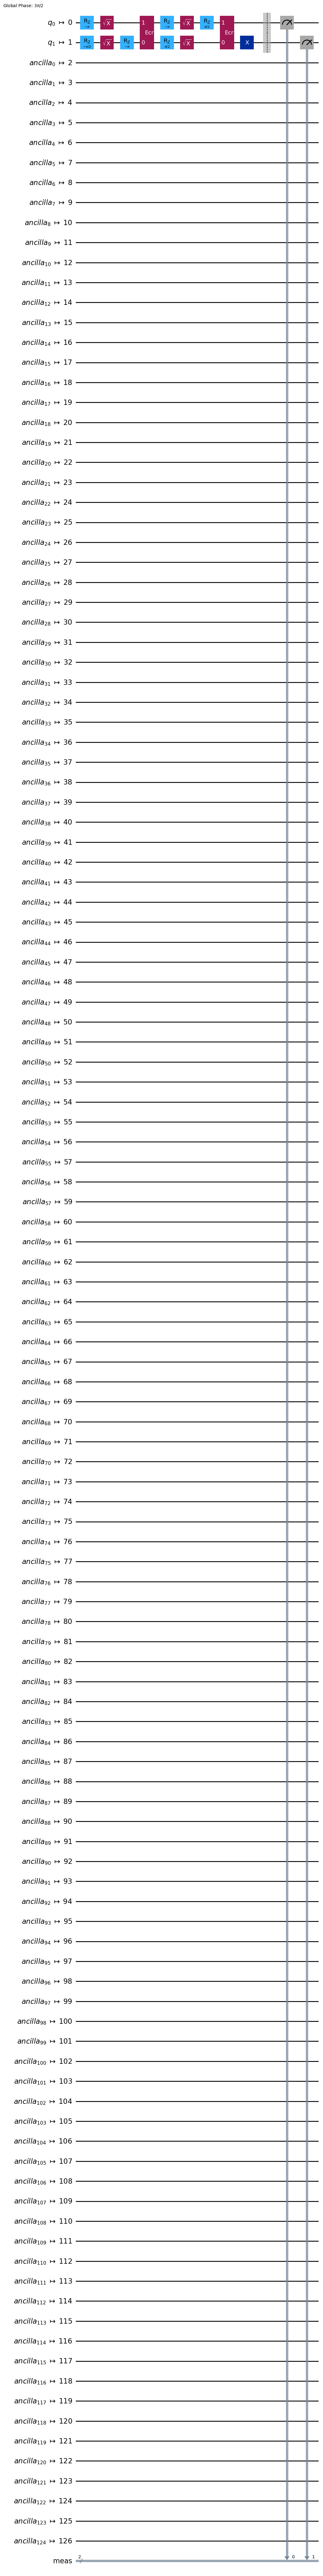

In [ ]:
# Debemos transpilar el circuito a las compuertas primivitas del computador

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
qc_trans = pm.run(qc)

qc_trans.draw(output='mpl')

In [ ]:
# Al inicializar el Sampler, debemos entregar el simulador o sistema que elegimos.

from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler = Sampler(backend=backend)

### 4.4     View job results.

Debemos invocar el método run() para generar los resultados.

In [ ]:
job = sampler.run([qc_trans])
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: crn7npetjdjg008b83rg
>>> Job Status: QUEUED


Counts for the meas output register: {'00': 2200, '10': 1843, '11': 31, '01': 22}


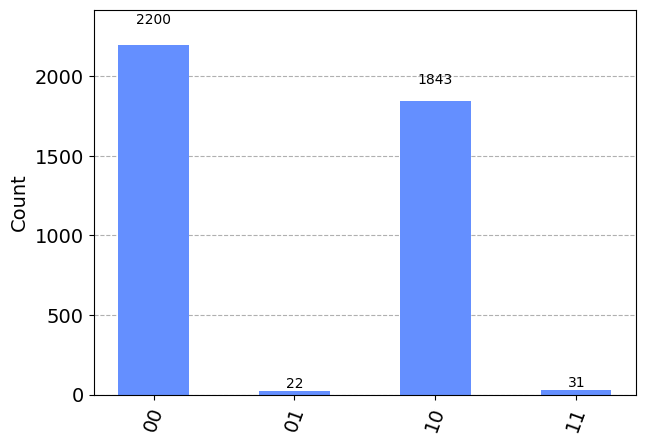

In [ ]:
# Obtener los resultados

result = job.result()[0]
counts = result.data.meas.get_counts()
print(f"Counts for the meas output register: {counts}")

# Graficar los resultados
plot_histogram( counts )

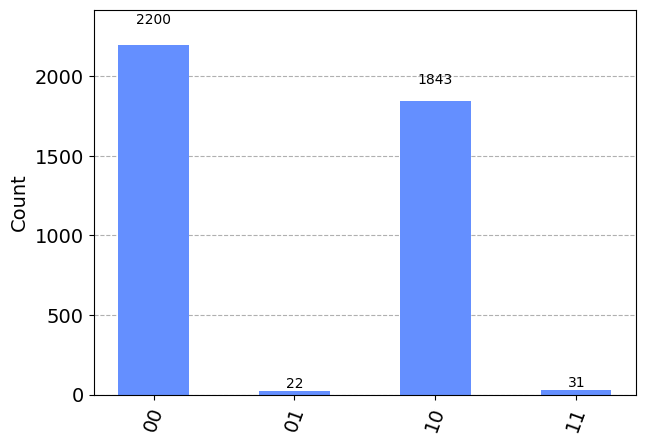

In [ ]:
# job_id = service.jobs(pending=False)[0].job_id() , jobid del último job

retrieved_job = service.job('crn7npetjdjg008b83rg')
result = retrieved_job.result()[0]
counts = result.data.meas.get_counts()

# Graficar los resultados
plot_histogram( counts )